In [57]:
import comet_ml
from comet_ml import Experiment
import matplotlib.pyplot as plt

In [58]:
# Building an experiment with your API key
experiment = Experiment(
    api_key="IkRq4zmkwF7SO5EiZAG4UjEVQ",
    project_name="CLINC",
    workspace="gdhanania",
)

# Setting hyperparameters
hyper_params = {"test_batch_size": 16, "dataset_subset" : "small"}

# Logging hyperparamters
experiment.log_parameters(hyper_params)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/gdhanania/clinc/05c7eceb1ad846ee9695f20eba028819



In [59]:
# NOTE: Based on your requirements, make changes to the variables:  checkpoints_out_dir, dataset_subset, predictions_out_dir, dataset_type

# dataset
dataset_name = 'clinc_oos'
dataset_subset = hyper_params['dataset_subset']

# model 
checkpoints_out_dir = '../checkpoints/clinc_small/checkpoint-15200'

#device
device = 'cuda:0'

# pipeline
pipeline_task = 'text-classification'

# predictions dir
predictions_out_dir = '../predictions/clinc_small_test.csv'

# dataset_type
dataset_type = 'test'

In [60]:
# load dataset
from datasets import load_dataset

dataset = load_dataset(dataset_name, dataset_subset, split = dataset_type)
dataset = dataset.rename_column("intent", "label")

dataset

Found cached dataset clinc_oos (/work/pi_adrozdov_umass_edu/gdhanania_umass_edu/hf_cache/datasets/clinc_oos/small/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


Dataset({
    features: ['text', 'label'],
    num_rows: 5500
})

In [61]:
# predict dataset
from transformers import pipeline
from sklearn.metrics import classification_report

classifier = pipeline(pipeline_task, model=checkpoints_out_dir, device=device)

# Make predictions on the dataset
predictions = classifier(dataset['text'], batch_size=hyper_params['test_batch_size'])

# Convert the predictions to a list of labels
predicted_labels = [p['label'] for p in predictions]
true_labels = [classifier.model.config.id2label[label] for label in dataset['label']]

In [62]:
# calculate f1 score for each label and accuracy
from sklearn.metrics import classification_report

with experiment.test():
    report = classification_report(true_labels, predicted_labels, output_dict=True)

    # report has three root variables 1. accuracy 2. macro avg 3. weighted avg
    macro_avg_f1_score = report['macro avg']['f1-score']
    weighted_avg_f1_score = report['weighted avg']['f1-score']

    accuracy = report['accuracy']

    print('Macro Average F1 score: {:.2f}'.format(macro_avg_f1_score))
    print('Weighted Average F1 score: {:.2f}'.format(weighted_avg_f1_score))
    print('Accuracy: {:.2f}%'.format(accuracy * 100))
    
    # Logging metrics
    experiment.log_metrics({
                            "Macro Average F1 score": macro_avg_f1_score, 
                            "Weighted Average F1 score" : weighted_avg_f1_score,
                            "Accuracy" : accuracy * 100
                           })

Macro Average F1 score: 0.90
Weighted Average F1 score: 0.85
Accuracy: 86.25%


In [63]:
import pandas as pd
df = pd.DataFrame(report)

df = df.transpose()
df = df.reset_index().rename(columns={'index': 'label'})
df = df[:-3] # removing accuracy, macro avg, weighted avg from the report
df.insert(df.columns.get_loc('label') + 1, 'label_index', [classifier.model.config.label2id[l] for l in df['label']])
df_sorted = df.sort_values(by='f1-score')
df_sorted.to_csv(predictions_out_dir, index = False)

,label,f1-score
0,oos,0.599584
1,order,0.643678
2,who_do_you_work_for,0.722222
3,sync_device,0.731707
4,shopping_list,0.738462
5,vaccines,0.759494
6,distance,0.761905
7,transactions,0.766667


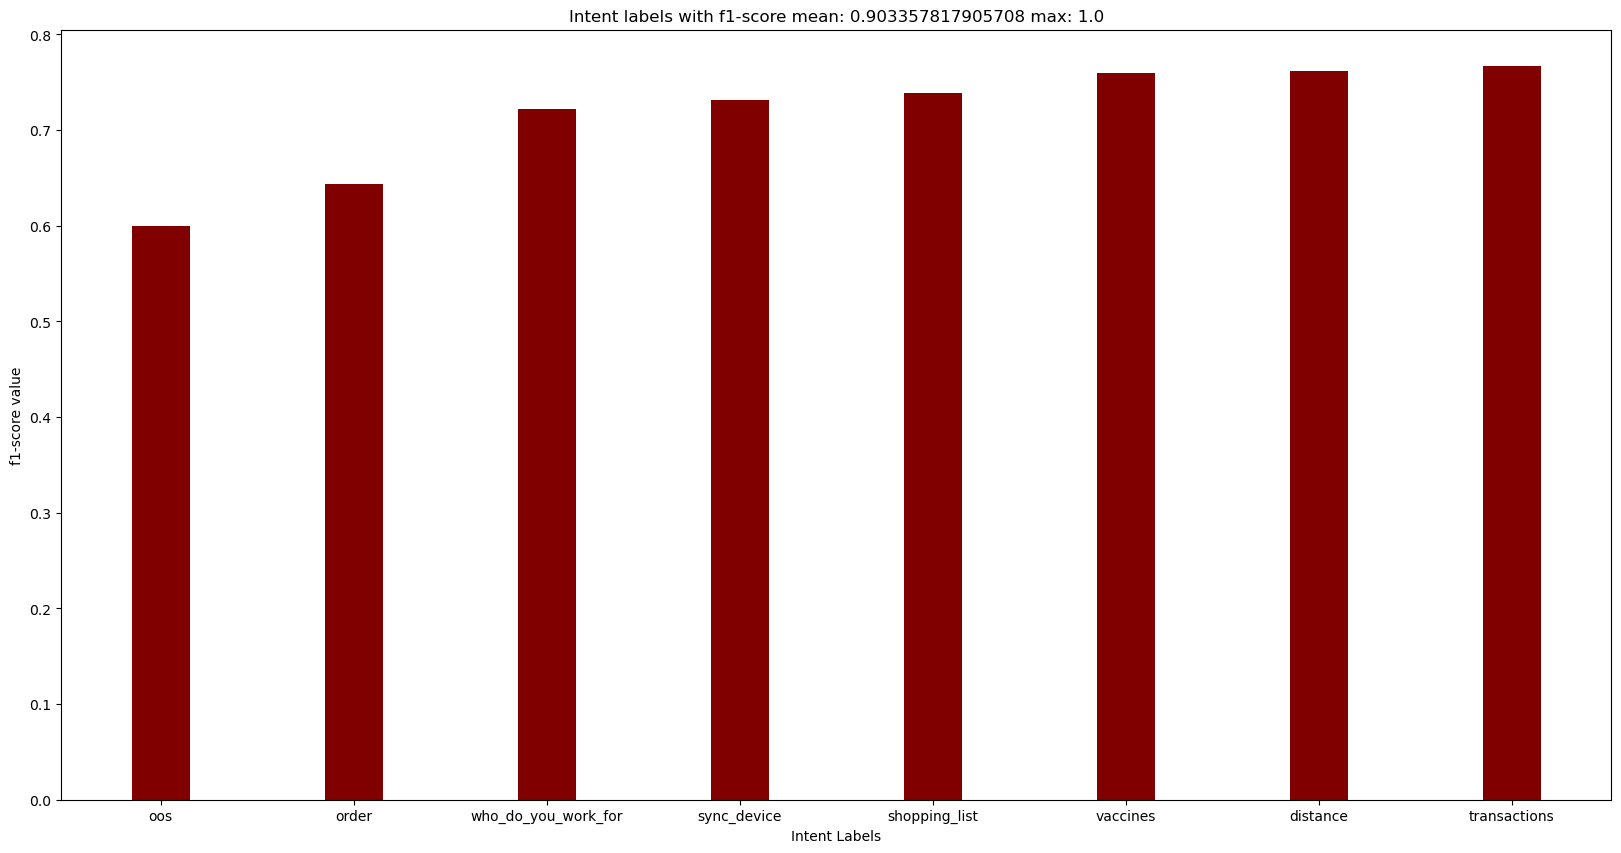

,label,precision
0,order,0.491228
1,sync_device,0.576923
2,vaccines,0.612245
3,who_do_you_work_for,0.619048
4,directions,0.625000
5,travel_suggestion,0.659091
6,ingredients_list,0.682927
7,shopping_list,0.685714


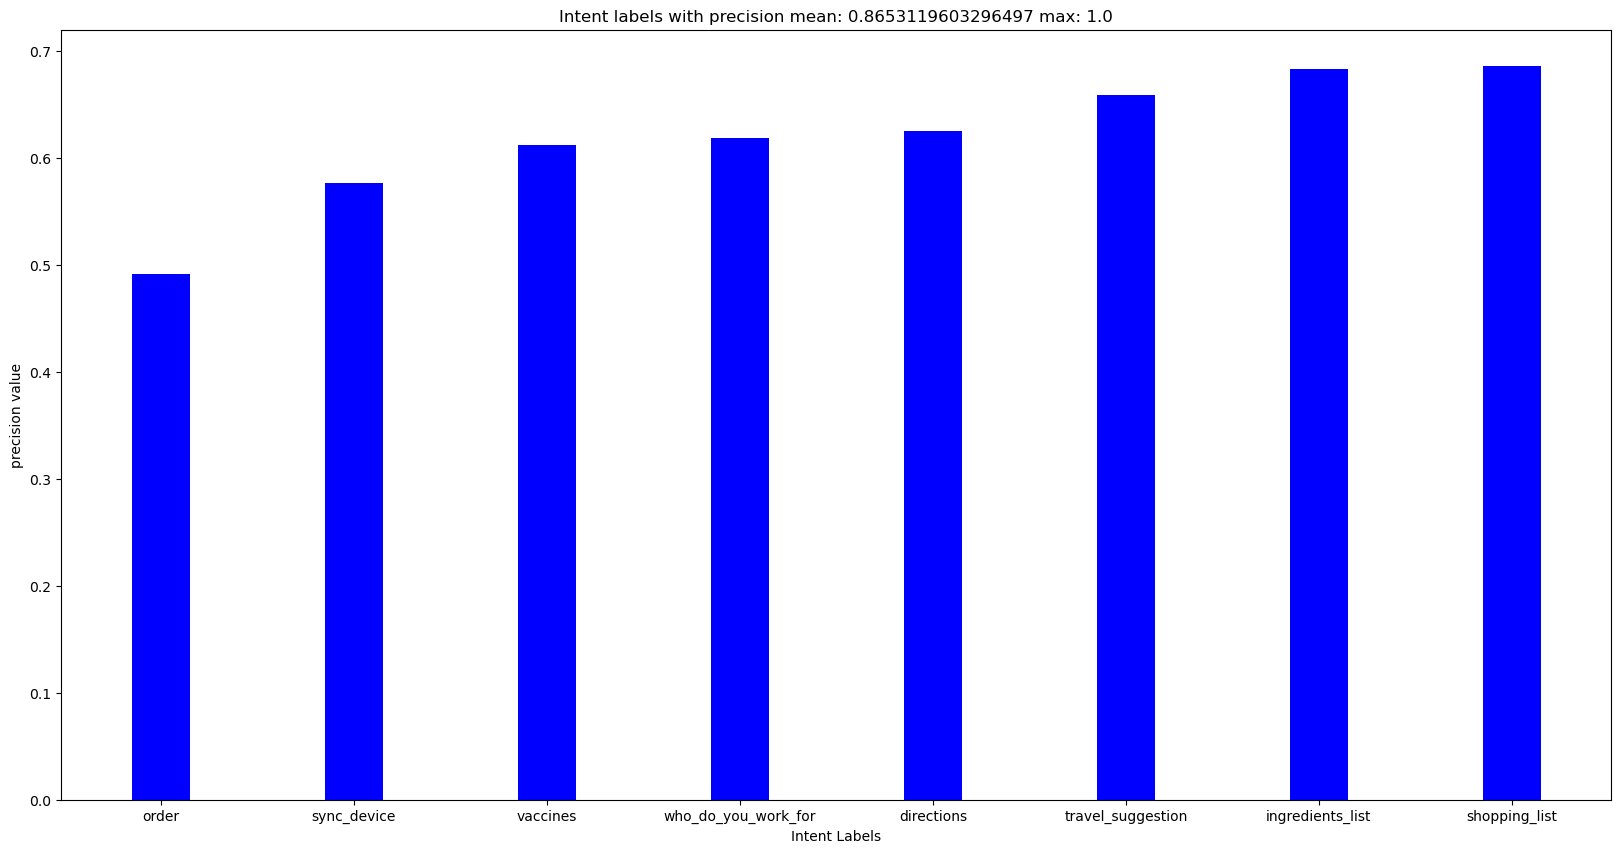

,label,recall
0,oos,0.432000
1,apr,0.733333
2,transactions,0.766667
3,calendar,0.766667
4,meal_suggestion,0.800000
5,shopping_list,0.800000
6,restaurant_reviews,0.800000
7,distance,0.800000


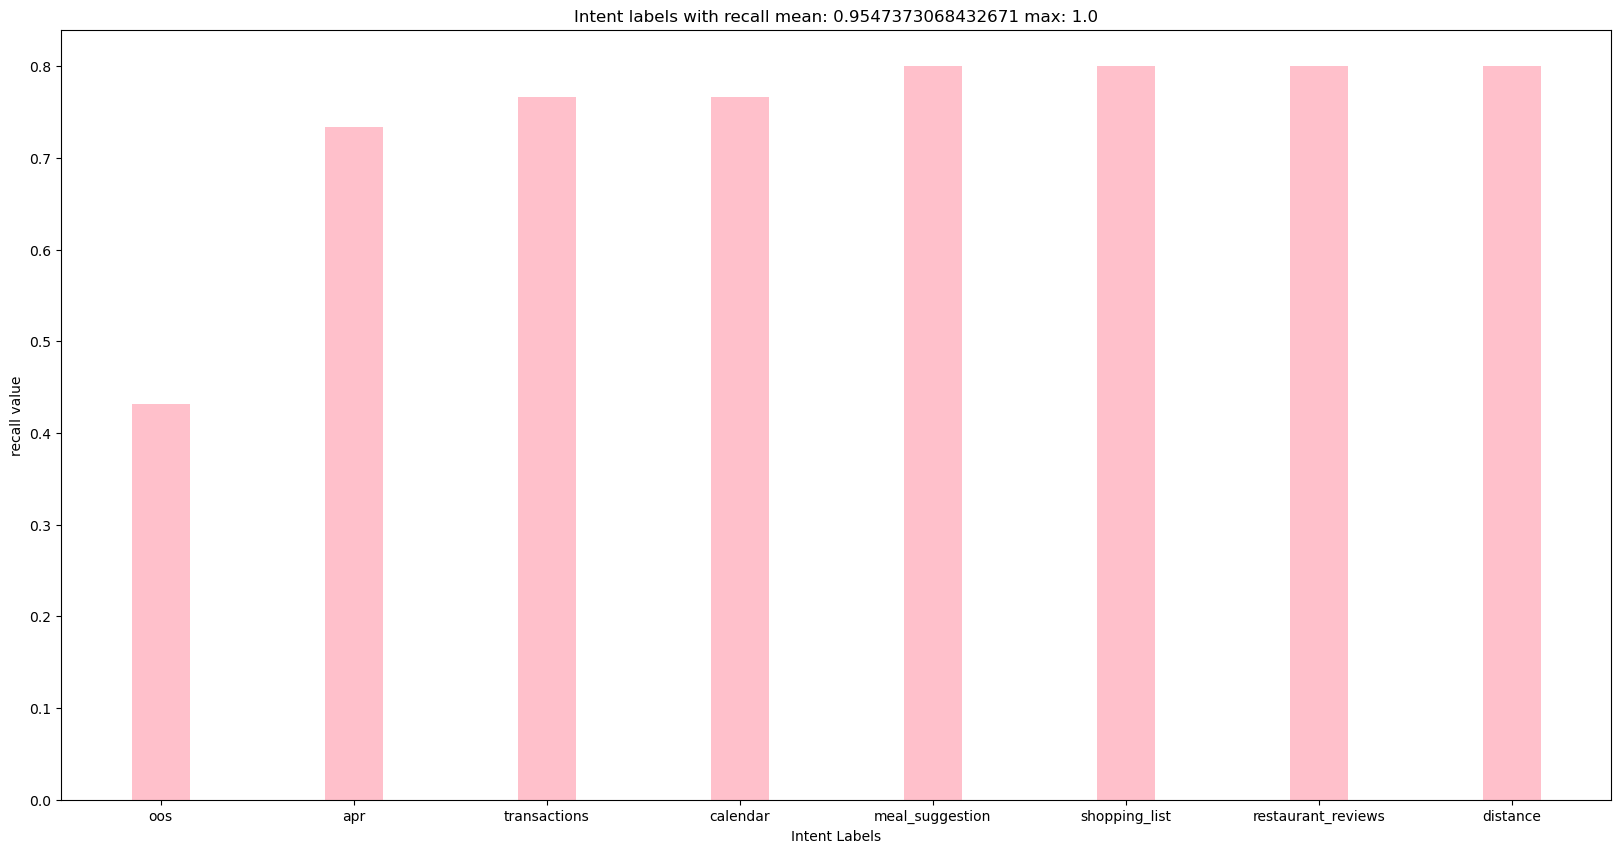

In [64]:
top_fraction = 0.05

def display_top_labels(df, metric_name, top_fraction = 0.10, color='black'):
    total_labels = df.shape[0]
    num_labels_to_report = int(top_fraction * total_labels)

    df_metric = df[['label', metric_name]]
    df_metric = df_metric.sort_values(by=metric_name)
    df_metric = df_metric.reset_index(drop=True)
    
    metric_mean = df_metric[metric_name].mean()
    metric_max = df_metric[metric_name].max()
    
    display(df_metric.loc[0:num_labels_to_report])
    df_metric = df_metric.loc[0:num_labels_to_report]
    
    fig = plt.figure(figsize = (20, 10))    
    label = df_metric.label
    metric = df_metric[metric_name]
    # creating the bar plot
    plt.bar(label, metric, color=color, width = 0.3)

    plt.xlabel("Intent Labels")
    plt.ylabel("" + metric_name + " value")
    plt.title("Intent labels with " + metric_name + " mean: " + str(metric_mean) + " max: " + str(metric_max))
    experiment.log_figure(figure=plt)
    plt.show()
    return df_metric

df_f1 = display_top_labels(df, 'f1-score', top_fraction, color='maroon')
df_precision = display_top_labels(df, 'precision', top_fraction, color='blue')
df_recall = display_top_labels(df, 'recall', top_fraction, color='pink')

In [65]:
# Create a Comet Artifact
artifact = comet_ml.Artifact(
    name="classification_metrics",
    artifact_type="result",
    aliases=["raw"],
    metadata={"task": "classification"},
)

artifact.add('../predictions/clinc_small_test.csv', metadata={"dataset_stage": "raw"})

experiment.add_tag("metric-upload")
experiment.log_artifact(artifact)

experiment.end()

COMET INFO: Artifact 'classification_metrics' version 2.0.0 created (previous was: 1.0.0)
COMET INFO: Scheduling the upload of 1 assets for a size of 9.68 KB, this can take some time
COMET INFO: Artifact 'gdhanania/classification_metrics:2.0.0' has started uploading asynchronously
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/gdhanania/clinc/05c7eceb1ad846ee9695f20eba028819
COMET INFO:   Metrics:
COMET INFO:     test_Accuracy                  : 86.25454545454545
COMET INFO:     test_Macro Average F1 score    : 0.903357817905708
COMET INFO:     test_Weighted Average F1 score : 0.8497830961677657
COMET INFO:   Parameters:
COMET INFO:     dataset_subset  : small
COMET INFO:     test_batch_size : 16
COMET INFO:   Uploads:
COMET INFO:     artifact assets              : 1 (9.68 KB)
COMET INFO:    